## Creating and simulating a simple model
Here we show how to create a basic model using basiCO, and simulating it. We start as usual by importing basiCO. 

In [1]:
import sys
if '../..' not in sys.path:
    sys.path.append('../..')
from basico import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now lets create a new model, passing along the `name` that we want to give it. Additional supported parameters for the model consist of: 

* `quantity_unit`: which sets the unit to use for species concentrations (defaults to mol)
* `volume_unit`: the unit to use for three dimensional compartments (defaults to litre (l))
* `time_unit`: the unit to use for time (defaults to second (s))
* `area_unit`: the unit to use for two dimensional compartments
* `length_unit`: the unit to use for one dimensional compartments

In [2]:
new_model(name='Simple Model');

now we add a basic rection that converts a chemical species `A` irreversibly into `B`. We can do that by just calling `addReaction` with the chemical formula to use. In this case this would be: `A -> B`. The reaction will be automatically created using mass action kinetics.  

In [3]:
add_reaction('R1', 'A -> B');

Since we had a new model, this created the Species `A` and `B` as well as a compartment `compartment`, in which those chemicals reside. The species have an initial concentration of 1. To verify we can call `get_species`, which returns a dataframe with all information about the species (either all species, or the one filtered to): 


In [4]:
get_species().initial_concentration

name
A    1.0
B    1.0
Name: initial_concentration, dtype: float64

to change the initial concentration, we use `set_species`, and specify which property we want to change: 

In [5]:
set_species('B', initial_concentration=0)
set_species('A', initial_concentration=10)
get_species().initial_concentration

name
A    10.0
B     0.0
Name: initial_concentration, dtype: float64

to see the kinetic paramters of our recation we can use `get_reaction_parameters`, and we see that the parameter has been created by default with a value of `0.1`

In [6]:
get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).k1,0.1,R1,local,


to change that parameter, we use `set_reaction_parameters`, specifying the value to be changed: 

In [7]:
set_reaction_parameters('(R1).k1', value=1)
get_reaction_parameters('k1')

,value,reaction,type,mapped_to
name,,,,
(R1).k1,1.0,R1,local,


now lets simulate our model for 10 seconds:

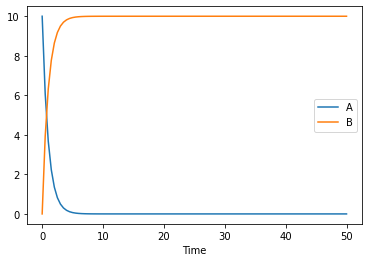

In [8]:
result = run_time_course(duration=50)
result.plot();


to simulate the model stochastically, you can specify the simulation method. COPASI supports many different simulations methods: 

* `deterministic`: using the COPASI LSODA implementation
* `stochastic`: using the Gibson Bruck algorithm
* `directMethod`: using the Gillespie direct method 

others are: 

* `tauleap`, `adaptivesa`, `radau5`, `hybridlsoda`, `hybridode45`

So lets try and simulate the model stochastically: 

In [9]:
result = run_time_course(duration=50, method='stochastic')

ERROR:root:Error while initializing the simulation: >ERROR 2021-04-20T12:20:04<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.


simulation failed in this time because the particle numbers, that the stochastic simulation is based upon is too high! Lets check: 

In [10]:
get_species().initial_particle_number

name
A    6.022141e+24
B    0.000000e+00
Name: initial_particle_number, dtype: float64

so we just set the initial particle number of a to be smaller, and run the simulation again, this time returning particle numbers rather than concentrations for the resulting dataframe

In [11]:
set_species('A', initial_particle_number=100)

Alternatively we could have modified the models quantity unit, which currently was set to: 

In [12]:
get_model_units()

{'time_unit': 's',
 'quantity_unit': 'mol',
 'length_unit': 'm',
 'area_unit': 'm²',
 'volume_unit': 'l'}

So initially we had a concentration of 10 mol/l, which does not lend itself for stochastic simulation. Using the `set_model_unit` command with a more apropriate `quantity_unit` and `volume_unit` would be the propper solution. 

When running stochastic simulations, you might want to specify the `seed` to be used, so that traces become reproducible. In COPASI you have two parameters for that `seed`, the actual seed, and `use_seed` a boolean indicating whether that seed is to be used for the next simulation. For a single trace we use both: 

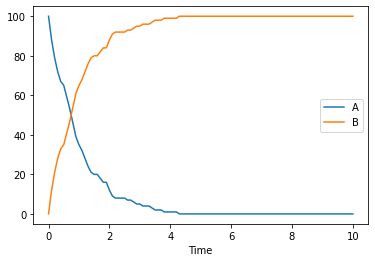

In [13]:
result = run_time_course(duration=10, method='stochastic', use_numbers=True, seed=1234, use_seed=True)
result.plot();

of course one stochastic trace will not be enough, so lets run many of them. This time the species will be plotted separately, so that it is easy to reuse the same color. This time we also don't use the seed specified before.  

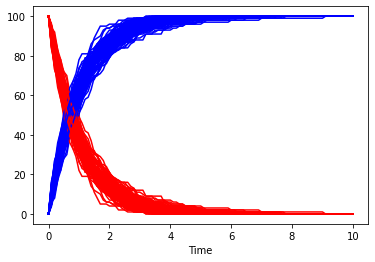

In [14]:
fig, ax = plt.subplots()
for i in range(100): 
    result = run_time_course(duration=10, method='stochastic', use_numbers=True, use_seed=False)
    result.plot(y='A', color='r', ax=ax, legend=None);
    result.plot(y='B', color='b', ax=ax, legend=None);

so far, we were only using mass action kinetics, but of course we could use any other kinetic as well. COPASI comes with a large number of functions already inbuilt. You can see those, running the `get_functions` command. It is filterable by name, and whether or not the formula is reversible, or general (general reactions can be used for either reversibility). Since we modelled our reaction as irreversible, lets look at the irreversible functions we have: 

In [15]:
get_functions(reversible=False)

,reversible,formula,general
name,,,
Allosteric inhibition (MWC),False,V*(substrate/Ks)*(1+(substrate/Ks))^(n-1)/(L*(...,False
Catalytic activation (irrev),False,V*substrate*Activator/((Kms+substrate)*(Ka+Act...,False
Competitive inhibition (irr),False,V*substrate/(Km+substrate+Km*Inhibitor/Ki),False
Constant flux (irreversible),False,v,False
Henri-Michaelis-Menten (irreversible),False,V*substrate/(Km+substrate),False
Hill Cooperativity,False,V*(substrate/Shalve)^h/(1+(substrate/Shalve)^h),False
Hyperbolic modifier (irrev),False,V*substrate*(1+b*Modifier/(a*Kd))/(Km*(1+Modif...,False
Mass action (irreversible),False,k1*PRODUCT<substrate_i>,False
Mixed activation (irrev),False,V*substrate*Activator/(Kms*(Kas+Activator)+sub...,False


So lets change the kinetic function that our reaction should use. Here we simply specify the function name that we got from the call before. This will introduce new local parameters, for `Km` and `Vmax` to the model. (We of course could have used the function parameter already add the `add_reaction` command above. 

In [16]:
set_reaction('R1', function='Henri-Michaelis-Menten (irreversible)')

In [17]:
get_reactions()

,scheme,flux,particle_flux,function
name,,,,
R1,A -> B,0.0,0.0,Henri-Michaelis-Menten (irreversible)


In [18]:
get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).Km,0.1,R1,local,
(R1).V,0.1,R1,local,


and now we can look at how the plot would look at repeating the simulation for several vmax values: 

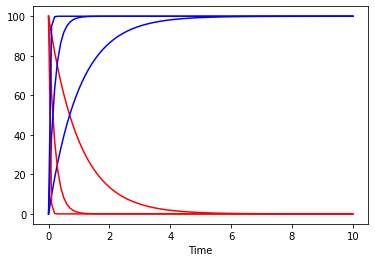

In [19]:
fig, ax = plt.subplots()
for vm in [0.1, 0.5, 3]:
    set_reaction_parameters('(R1).V', value=vm)
    result = run_time_course(duration=10, method='deterministic', use_numbers=True)
    result.plot(y='A', color='r', ax=ax, legend=None);
    result.plot(y='B', color='b', ax=ax, legend=None);